# Disaggregation Test

To test if daily rainfall evenly split into 3-hour segments will produce the same simulation output as daily rainfall.

### Imports

In [116]:
# General Usage
import glob
import os

# Data
import numpy as np
import pandas as pd

# Simulation
from pyswmm import Simulation
from swmmtoolbox import swmmtoolbox

# Plotting
import matplotlib.pyplot as plt
import calendar

## Timeseries Formatting

### Chicago Timeseries

#### Disaggregated

In [71]:
daily = pd.read_pickle('../daily_extracted_data/chicago.pkl').squeeze()

disaggregated = (daily / 8).repeat(8).reset_index(drop=True).to_frame('precipitation')

timeseries_name = 'NARR_DISAGGREGATION_TEST_3HR'
date_range = pd.date_range(start='1/1/2014', end='1/1/2015', freq='3H')[:-1]

disaggregated['date'] = date_range.strftime('%m/%d/%Y')
disaggregated['time'] = date_range.time.astype(str)
disaggregated['name'] = timeseries_name

disaggregated = disaggregated[['name', 'date', 'time', 'precipitation']]
data = disaggregated.to_numpy()

np.savetxt('./timeseries/chicago_disaggregate.txt', data, delimiter='\t', fmt='%s')

#### Normal Daily

In [91]:
daily = pd.read_pickle('../daily_extracted_data/chicago.pkl')
daily = daily.rename({1: 'precipitation'}, axis='columns')

timeseries_name = 'NARR_DISAGGREGATION_TEST_DAILY'
date_range = pd.date_range(start='1/1/2014', end='1/1/2015', freq='D')[:-1]
daily['date'] = date_range.strftime('%m/%d/%Y')
daily['time'] = date_range.time.astype(str)
daily['name'] = timeseries_name

daily = daily[['name', 'date', 'time', 'precipitation']]

data = daily.to_numpy()
np.savetxt('./timeseries/chicago_daily.txt', data, delimiter='\t', fmt='%s')

### California Timeseries
#### Disaggregated

In [119]:
daily = pd.read_pickle('../daily_extracted_data/california.pkl').squeeze()

disaggregated = (daily / 8).repeat(8).reset_index(drop=True).to_frame('precipitation')

timeseries_name = 'NARR_DISAGGREGATION_TEST_3HR'
date_range = pd.date_range(start='1/1/2014', end='1/1/2015', freq='3H')[:-1]

disaggregated['date'] = date_range.strftime('%m/%d/%Y')
disaggregated['time'] = date_range.time.astype(str)
disaggregated['name'] = timeseries_name

disaggregated = disaggregated[['name', 'date', 'time', 'precipitation']]
data = disaggregated.to_numpy()

np.savetxt('./timeseries/california_disaggregate.txt', data, delimiter='\t', fmt='%s')

#### Daily

In [120]:
daily = pd.read_pickle('../daily_extracted_data/california.pkl')
daily = daily.rename({1: 'precipitation'}, axis='columns')

timeseries_name = 'NARR_DISAGGREGATION_TEST_DAILY'
date_range = pd.date_range(start='1/1/2014', end='1/1/2015', freq='D')[:-1]
daily['date'] = date_range.strftime('%m/%d/%Y')
daily['time'] = date_range.time.astype(str)
daily['name'] = timeseries_name

daily = daily[['name', 'date', 'time', 'precipitation']]

data = daily.to_numpy()
np.savetxt('./timeseries/california_daily.txt', data, delimiter='\t', fmt='%s')

## Running the Simulation

In [121]:
for bg in ['california', 'chicago']:
    files = glob.glob('./input_files/' + bg + '/*.inp')
    for file in files:
        sim = Simulation(file)
        sim.execute()


... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete
... SWMM Version 5.3.0.dev0
... Run Complete

## Extracting the Data

#### Chicago

In [102]:
out_dir = './extracted_sim_data/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

extract_vars = [['system', 'Rainfall', 'Rainfall'],['system','Runoff','Runoff'],['system','Evaporation_infiltration','Evaporation_infiltration']]
        
output_files = glob.glob('./input_files/chicago/*.out')
for file in output_files:
    sim_type = file[file.rfind('_')+1:file.rfind('.')]
    data = swmmtoolbox.extract(file, *extract_vars)
    data['system__Runoff'] = data['system__Runoff'] / 4933.82198249943
    data.to_pickle(out_dir + './chicago_' + sim_type + '.pkl')

/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/swmmtoolbox/swmmtoolbox.py:800: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  result = pd.concat(jtsd, axis=1, join_axes=[jtsd[0].index])


#### California

In [122]:
out_dir = './extracted_sim_data/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

extract_vars = [['system', 'Rainfall', 'Rainfall'],['system','Runoff','Runoff'],['system','Evaporation_infiltration','Evaporation_infiltration']]
        
output_files = glob.glob('./input_files/california/*.out')
for file in output_files:
    sim_type = file[file.rfind('_')+1:file.rfind('.')]
    data = swmmtoolbox.extract(file, *extract_vars)
    data['system__Runoff'] = data['system__Runoff'] / 4933.82198249943
    data.to_pickle(out_dir + './california_' + sim_type + '.pkl')

/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/swmmtoolbox/swmmtoolbox.py:800: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  result = pd.concat(jtsd, axis=1, join_axes=[jtsd[0].index])


## Plots

Rainfall


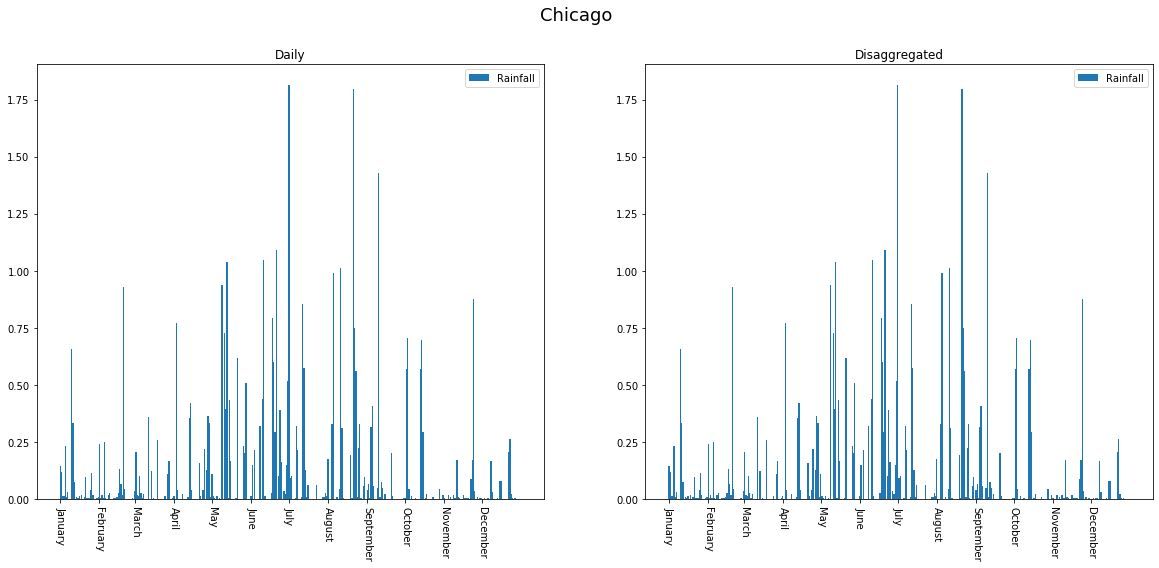

Evaporation_infiltration


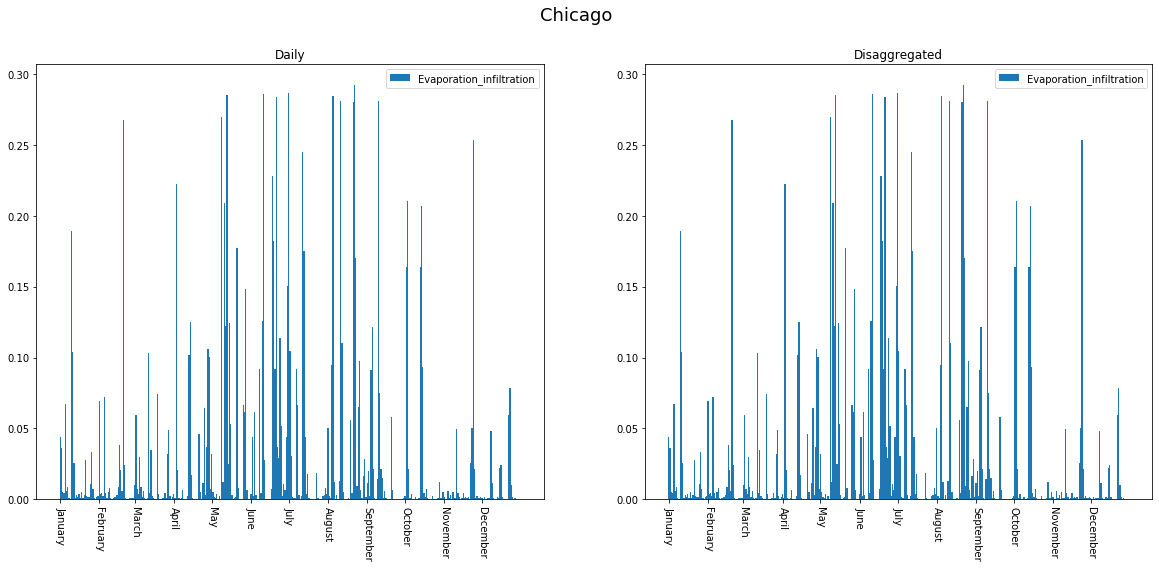

Runoff


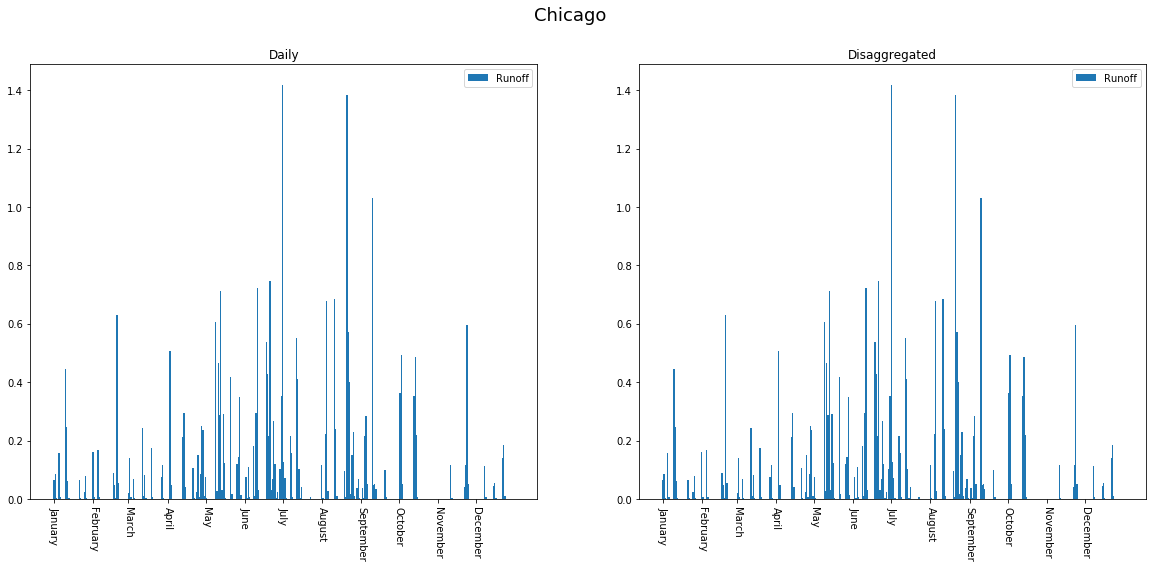

Rainfall


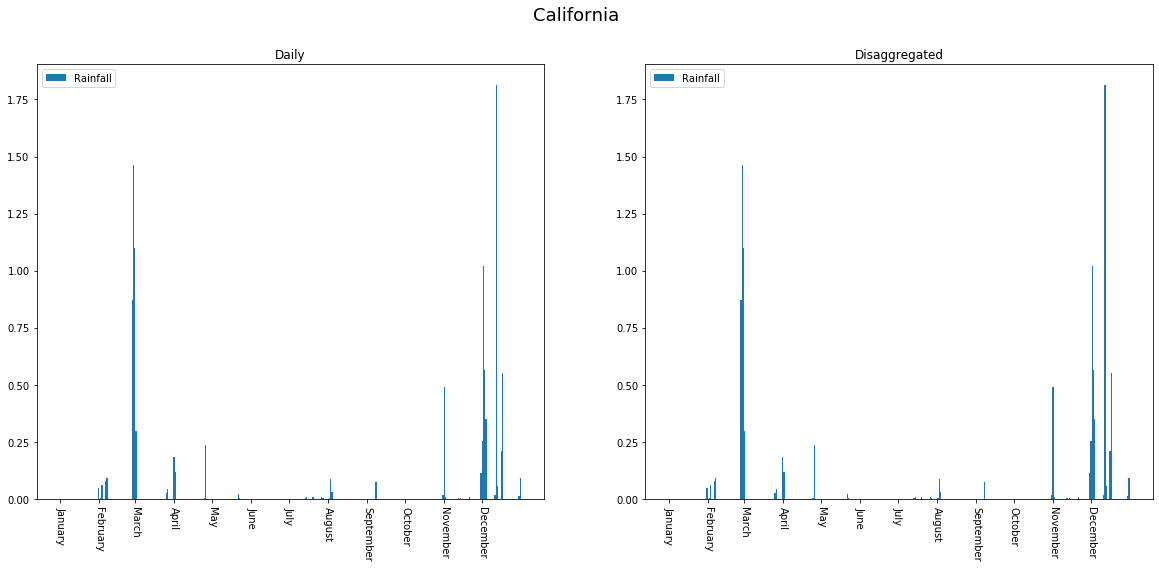

Evaporation_infiltration


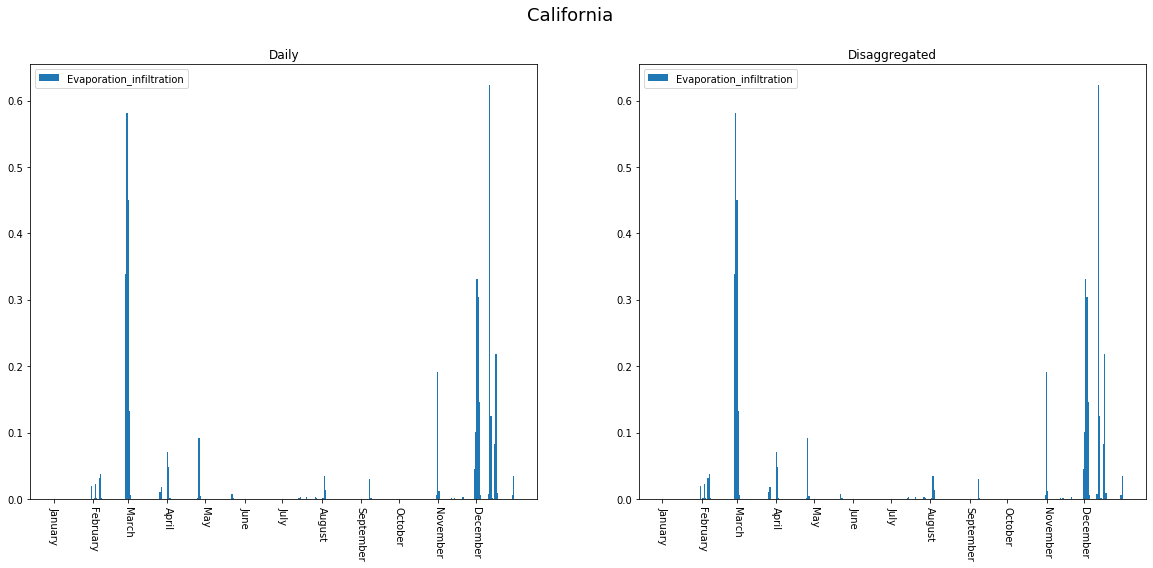

Runoff


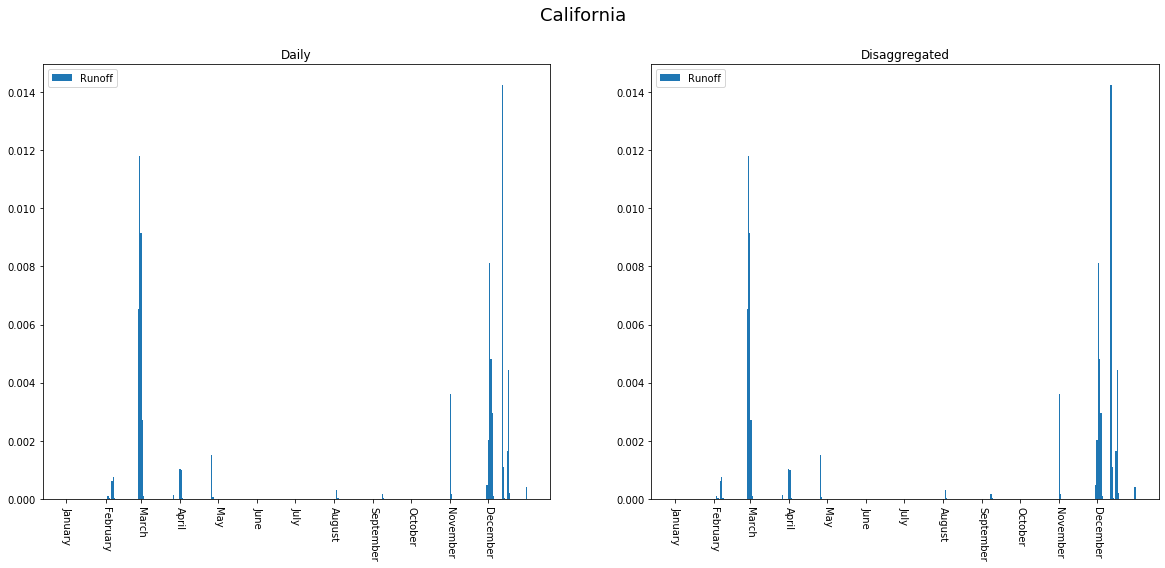

In [124]:
date = [i for i in range(365)]

for bg in ['chicago', 'california']:
    daily_data = pd.read_pickle('./extracted_sim_data/' + bg + '_daily.pkl').resample('d').sum()
    disaggregated_data = pd.read_pickle('./extracted_sim_data/' + bg + '_disaggregated.pkl').resample('d').sum()

    name = bg[0].upper() + bg[1:]

    for data in ['system__Rainfall', 'system__Evaporation_infiltration', 'system__Runoff']:
        width = 1.0
        data_name = data[8:]
        print(data_name)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

        fig.suptitle(name, fontsize=18)

        axes[0].set_title('Daily')
        axes[0].bar(date, daily_data[data], width, label=data_name)
        axes[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[0].legend()

        axes[1].set_title('Disaggregated')
        axes[1].bar(date, disaggregated_data[data], width, label=data_name)
        axes[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[1].legend()

        plt.autoscale()
        plt.savefig('./plots/' + bg + '/' + data_name + '.svg')
        plt.show()

## Difference in Data

We will subtract the disaggregated data from the daily data. Ideally the result will be zero, this means they are the same.

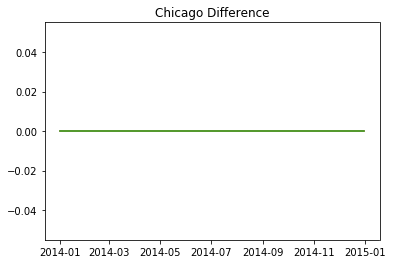

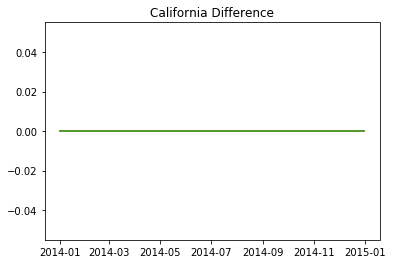

In [134]:
for bg in ['chicago', 'california']:
    name = bg[0].upper() + bg[1:]
    daily = pd.read_pickle('./extracted_sim_data/' + bg + '_daily.pkl').resample('d').sum()
    disaggregated = pd.read_pickle('./extracted_sim_data/' + bg + '_disaggregated.pkl').resample('d').sum()
    
    diff = daily - disaggregated
    plt.title(name + ' Difference')
    plt.plot(diff)
    plt.savefig('./plots/difference/' + bg + '.svg', dpi=900)
    plt.show()
    